In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score, root_mean_squared_error

# Plot Predictions

In [ ]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (n months shift)
n = 6
for shift_val in range(1, n+1):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_{shift_val}'
        df[column_name] = df[column].shift(shift_val)
        df.fillna(df[column].values[0], inplace=True)

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])  # Use only n-month-shifted features
y = df['cotacao']

# # Specify training period 
train_year = 2022
train_month = 1
window = 3  
train_end = df[(df['ano'] == train_year) & (df['mes'] == train_month)].index
train_end = train_end.item()

# Define train and test sets
train_idx = train_end + 1  
X_train = X.loc[:train_idx - 1]  
y_train = y.loc[:train_idx - 1]
X_test = X.loc[train_idx:train_idx + window - 1] 
y_test = y.loc[train_idx:train_idx + window - 1]
display(df.loc[train_idx:train_idx + window - 1] )

# Separar treino e teste preservando a ordem temporal
# train_size = int(len(df) * 0.90) # Digite o número em meses se quiser
# window = abs(train_size - int(len(df))) # abs(train_size - int(len(df))) for max left # Digite a quantidade de meses se quiser
# X_train, X_test = X.loc[:train_size - 1], X.loc[train_size:train_size + window - 1]  
# y_train, y_test = y.loc[:train_size - 1], y.loc[train_size:train_size + window - 1]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define SVR model and parameters
svr = SVR()
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf']
}

# Time series cross-validation for training data
tscv = TimeSeriesSplit(n_splits=5)  # Default splits for test size

# Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=svr,
    search_spaces=param_grid,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Fit model
bayes_search.fit(X_train_scaled, y_train)
best_svr = bayes_search.best_estimator_

# Predict for the test period
y_pred = best_svr.predict(X_test_scaled)

# Calculate residuals and uncertainty
residuals = y_train - best_svr.predict(X_train_scaled)
std_dev = np.std(residuals)
mul_std = 2  #Uncertainty interval
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev

# Identify outliers
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)
outliers_df = pd.DataFrame({
    'Date': df.loc[train_idx:train_idx + window - 1]['ano'].astype(str) + '-' + df.loc[train_idx:train_idx + window - 1]['mes'].astype(str),
    #'Date': df.loc[train_size:train_size + window - 1]['ano'].astype(str) + '-' + df.loc[train_size:train_size + window - 1]['mes'].astype(str),
    'True Cotacao': y_test.values,
    'Predicted Cotacao': y_pred,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Is Outlier': outliers_mask
})
outliers_df = outliers_df[outliers_df['Is Outlier']]

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
outlier_rate = (len(outliers_df) / len(y_test)) * 100  # Percentage of outliers

# Print results, focusing on MAE, MAPE, and outlier rate
print("Best parameters from training:", bayes_search.best_params_)
print(f"CV score (MAE): {-bayes_search.best_score_:.4f}")
print(f"Test MAE (next {window} months): {mae:.4f}")
print(f"Test MAPE (next {window} months): {mape:.2f}%")
print(f"Outlier rate (next {window} months): {outlier_rate:.2f}%")
print(f"\nOutlier Details (Next {window} Months):")
display(outliers_df)


# Visualize results 
plt.figure(figsize=(10, 6)) 
plot_dates = df.loc[train_idx:train_idx + window - 1]['ano'].astype(str) + '-' + df.loc[train_idx:train_idx + window - 1]['mes'].astype(str)
#plot_dates = df.loc[train_size:train_size + window - 1]['ano'].astype(str) + '-' + df.loc[train_size:train_size + window - 1]['mes'].astype(str)

plt.plot(plot_dates, y_test.values, label="Cotação Real", color="blue")
plt.plot(plot_dates, y_pred, label="Cotação Predita", color="red", linestyle="--")
plt.fill_between(plot_dates, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=rf"{mul_std}$\pm\sigma$")
plt.scatter(outliers_df['Date'], outliers_df['True Cotacao'], 
            color='black', marker='o', label="Outliers")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title(f"SVR Prediction: Cotação Real vs Predita com Incerteza e Outliers - (Janela de {n}), ({window} Meses a partir de {plot_dates.values[0]})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Detect Outliers

Found Outlier :{'Date': '2002-1', 'True Cotacao': 2.413, 'Predicted Cotacao': 2.429646092007273, 'Lower Bound': 2.424794470159891, 'Upper Bound': 2.434497713854655}
Found Outlier :{'Date': '2002-2', 'True Cotacao': 2.365, 'Predicted Cotacao': 2.4716240466401276, 'Lower Bound': 2.4668585965428713, 'Upper Bound': 2.476389496737384}
Found Outlier :{'Date': '2002-4', 'True Cotacao': 2.361, 'Predicted Cotacao': 2.3005153430253493, 'Lower Bound': 2.2960378779241593, 'Upper Bound': 2.3049928081265394}
Found Outlier :{'Date': '2002-5', 'True Cotacao': 2.518, 'Predicted Cotacao': 2.371723835657849, 'Lower Bound': 2.2966673794972916, 'Upper Bound': 2.4467802918184063}
Found Outlier :{'Date': '2002-6', 'True Cotacao': 2.8175, 'Predicted Cotacao': 2.5276833283246543, 'Lower Bound': 2.5219843055962228, 'Upper Bound': 2.5333823510530857}
Found Outlier :{'Date': '2002-7', 'True Cotacao': 3.46, 'Predicted Cotacao': 2.749276999705699, 'Lower Bound': 2.6661664746815337, 'Upper Bound': 2.8323875247298647

,Date,True Cotacao,Predicted Cotacao,Lower Bound,Upper Bound
0,2002-1,2.4130,2.429646,2.424794,2.434498
1,2002-2,2.3650,2.471624,2.466859,2.476389
2,2002-4,2.3610,2.300515,2.296038,2.304993
3,2002-5,2.5180,2.371724,2.296667,2.446780
4,2002-6,2.8175,2.527683,2.521984,2.533382
5,2002-7,3.4600,2.749277,2.666166,2.832388
6,2002-8,3.0075,4.040680,4.029885,4.051475
7,2002-9,3.7600,2.828686,2.531186,3.126186
8,2002-10,3.6500,3.977819,3.816456,4.139182
9,2002-11,3.6530,3.886562,3.702008,4.071117


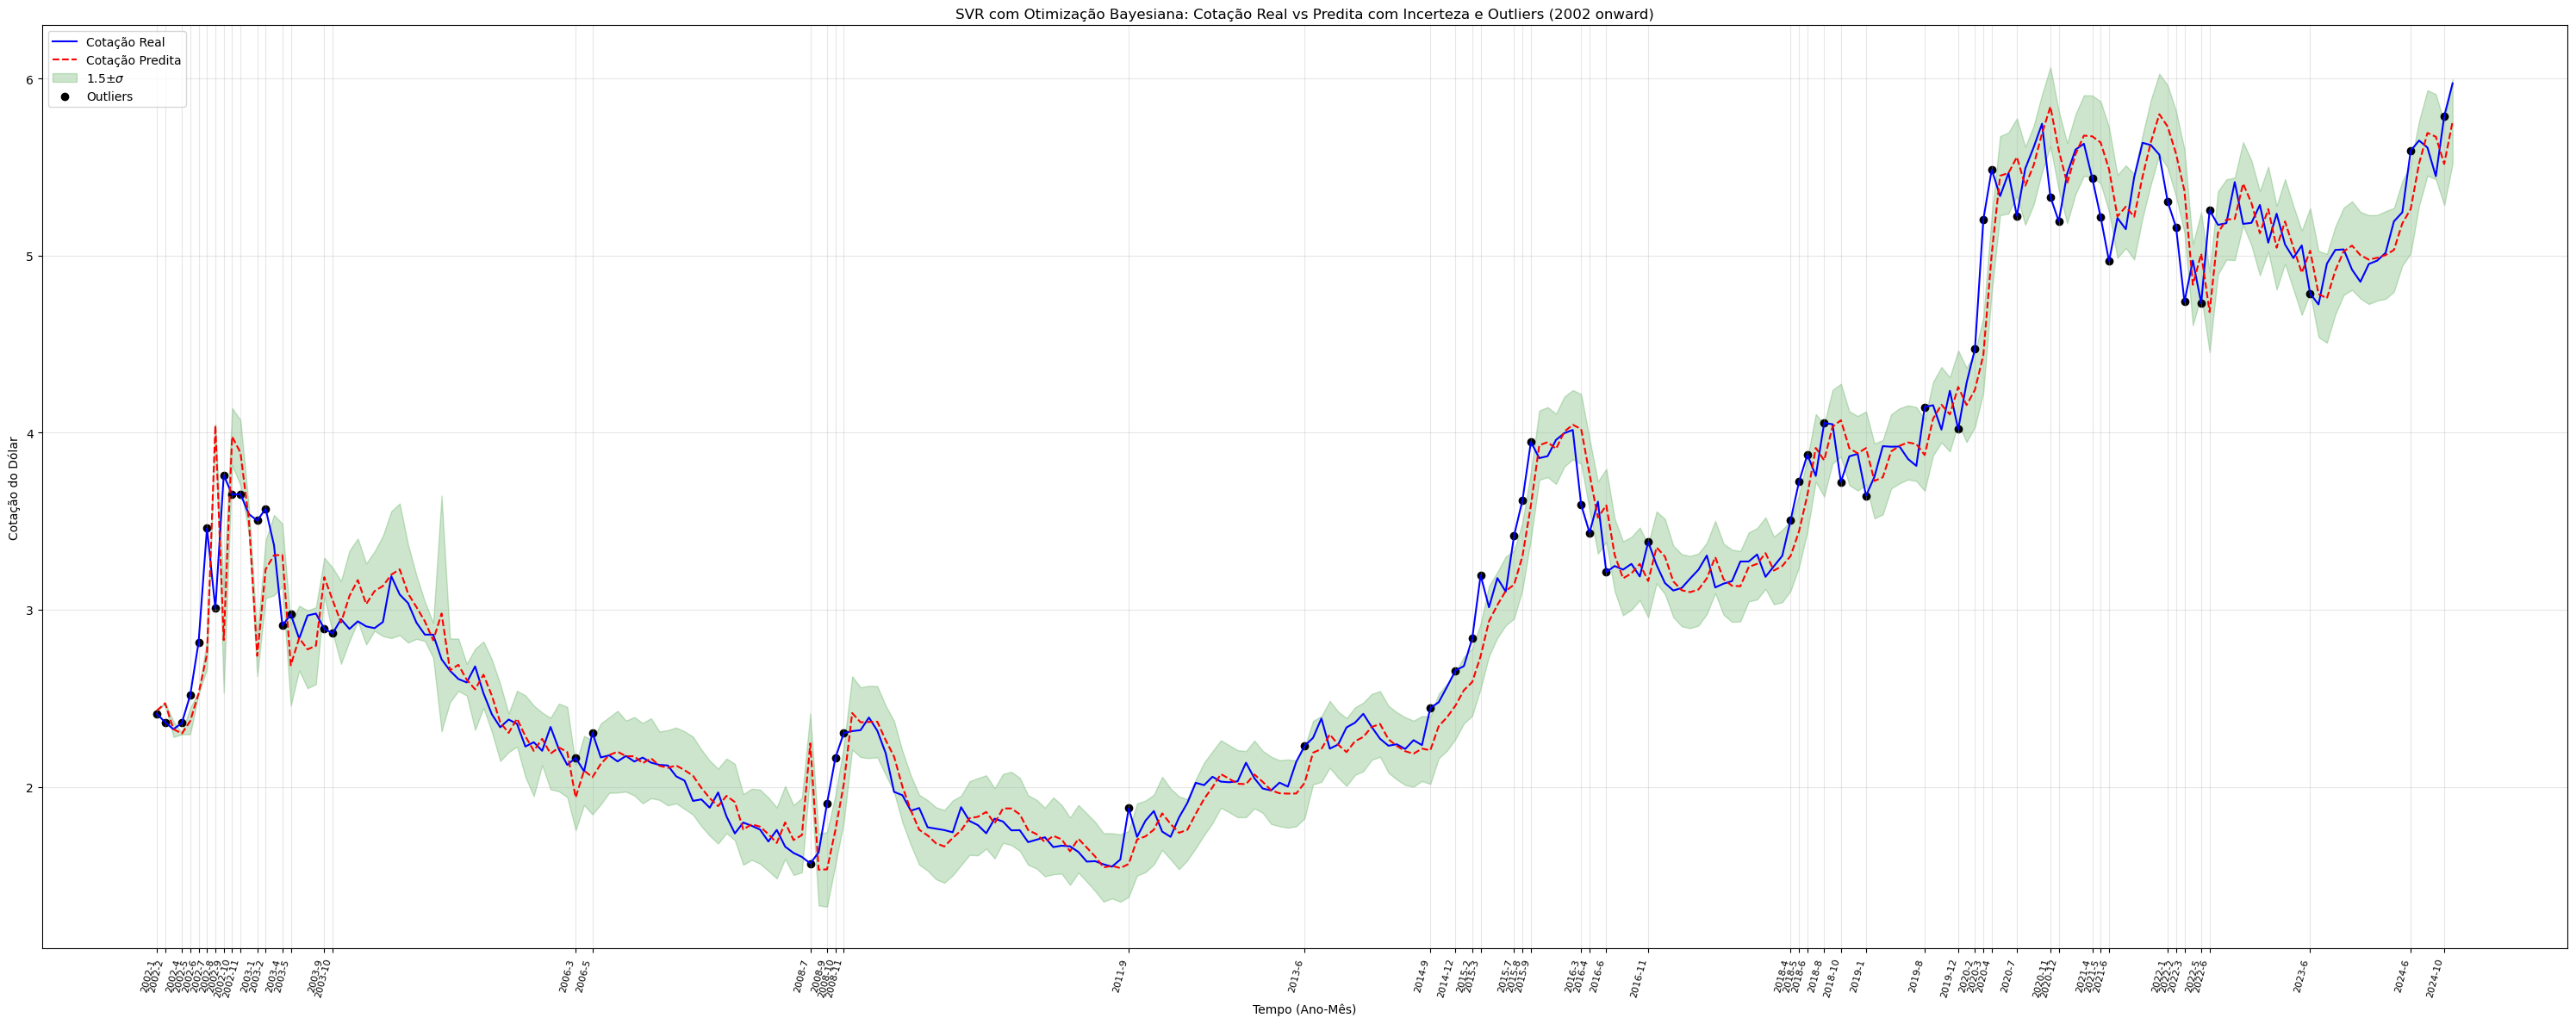

In [2]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (n months shift)
n = 6
for shift_val in range(1, n+1):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_lag{shift_val}'
        df[column_name] = df[column].shift(shift_val)
        df.fillna(df[column].values[0], inplace=True)

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])  # Use only 6-month-shifted features
y = df['cotacao']

# Initialize lists for predictions and outliers
predictions_list = []
outliers_list = []


# Train until end of 2001, then predict and retrain monthly
ano = 2001
train_end_2002 = df[df['ano'] == ano].index[-1]  
current_idx = train_end_2002 + 1  # Start predicting from January 2003

while current_idx < len(df):
    # Define training data (up to current month - 1)
    train_idx = slice(None, current_idx)
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define SVR model and parameters
    svr = SVR()
    param_grid = {
        'C': (0.1, 1000.0, 'log-uniform'),
        'epsilon': (0.0001, 1.0, 'log-uniform'),
        'gamma': (1e-5, 1.0, 'log-uniform'),
        'kernel': ['rbf']
    }

    # Time series cross-validation for training data
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Bayesian optimization
    bayes_search = BayesSearchCV(
        estimator=svr,
        search_spaces=param_grid,
        n_iter=40,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        return_train_score=True
    )

    # Fit model
    bayes_search.fit(X_train_scaled, y_train)
    best_svr = bayes_search.best_estimator_

    # Prepare data for prediction (current month)
    X_pred = X.iloc[current_idx:current_idx + 1]
    X_pred_scaled = scaler.transform(X_pred)
    y_actual = y.iloc[current_idx]

    # Predict and calculate uncertainty (std)
    y_pred = best_svr.predict(X_pred_scaled)[0]
    residuals = y_train - best_svr.predict(X_train_scaled)
    std_dev = np.std(residuals)
    mul_std = 1.5  # Uncertainty
    lower_bound = y_pred - mul_std * std_dev
    upper_bound = y_pred + mul_std * std_dev
    
    # Save prediction details
    date = f"{df.loc[current_idx, 'ano']}-{df.loc[current_idx, 'mes']}"
    predictions_list.append({
        'Date': date,
        'True Cotacao': y_actual,
        'Predicted Cotacao': y_pred,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    # Check if actual value is an outlier
    is_outlier = (y_actual < lower_bound) | (y_actual > upper_bound)
    if is_outlier:
        #date = f"{df.iloc[current_idx]['ano']}-{df.iloc[current_idx]['mes']}"
        outliers_list.append({
            'Date': date,
            'True Cotacao': y_actual,
            'Predicted Cotacao': y_pred,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })
        print(f'Found Outlier :{outliers_list[-1]}')

    # Move to next month
    current_idx += 1

    # Print progress (optional)
    if current_idx % 12 == 0:  # Print every year
        date = f"{df.iloc[current_idx-1]['ano']}-{df.iloc[current_idx-1]['mes']}"
        print(f"Processed up to {date}")
        
# Create DataFrames from lists
predictions_df = pd.DataFrame(predictions_list)
outliers_df = pd.DataFrame(outliers_list)
outliers_df.to_csv(f'Outliers/SVR_BayesOpt_Outliers_{mul_std}std.csv',index=False)


# Calculate overall metrics
y_pred_all = predictions_df['Predicted Cotacao'].values
y_actual_all = predictions_df['True Cotacao'].values
mae = mean_absolute_error(y_actual_all, y_pred_all)
mape = mean_absolute_percentage_error(y_actual_all, y_pred_all) * 100
rmse = root_mean_squared_error(y_actual_all, y_pred_all)
r2_all = r2_score(y_actual_all, y_pred_all)
outlier_rate = (len(outliers_df) / len(predictions_df)) * 100

# Print results
print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall MAE: {mae:.4f}")
print(f"Overall MAPE: {mape:.2f}%")
print(f"Overall R² score: {r2_all:.2f}")
print(f"Outlier rate: {outlier_rate:.2f}%")
print("\nOutlier Details:")
display(outliers_df)

# Visualize results
plt.figure(figsize=(30, 12))
plot_dates = predictions_df['Date'].values
plt.plot(plot_dates, y_actual_all, label="Cotação Real", color="blue")
plt.plot(plot_dates, y_pred_all, label="Cotação Predita", color="red", linestyle="--")
plt.fill_between(plot_dates, predictions_df['Lower Bound'], predictions_df['Upper Bound'], 
                 color='green', alpha=0.2, label=rf"{mul_std}$\pm\sigma$")
plt.scatter(outliers_df['Date'], outliers_df['True Cotacao'], 
            color='black', marker='o', label="Outliers")
plt.xticks(outliers_df['Date'].values,rotation=75, ha='right',fontsize=8)
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title(f"SVR com Otimização Bayesiana: Cotação Real vs Predita com Incerteza e Outliers ({ano+1} onward)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"Plots/SVR_BayesOpt_Outliers_{mul_std}std.png", format='png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize results
plt.figure(figsize=(30, 12))
plot_dates = predictions_df['Date'].values
plt.plot(plot_dates, y_actual_all, label="Cotação Real", color="blue")
plt.plot(plot_dates, y_pred_all, label="Cotação Predita", color="red", linestyle="--")
plt.fill_between(plot_dates, predictions_df['Lower Bound'], predictions_df['Upper Bound'], 
                 color='green', alpha=0.2, label=rf"{mul_std}$\pm\sigma$")
plt.scatter(outliers_df['Date'], outliers_df['True Cotacao'], 
            color='black', marker='o', label="Outliers")
plt.xticks(outliers_df['Date'].values,rotation=75, ha='right',fontsize=8)
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title(f"SVR com Otimização Bayesiana: Cotação Real vs Predita com Incerteza e Outliers ({ano+1} onward)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"Plots/SVR_BayesOpt_Outliers_{mul_std}std.png", format='png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
plot_dates